In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Imports
import numpy as np   
import pandas as pd   
import os 
import tensorflow as tf 
from keras.preprocessing.sequence import pad_sequences 
from keras.preprocessing.text import Tokenizer 
from keras.models import Model 
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation 
from keras.layers import concatenate, BatchNormalization, Input
from keras.layers.merge import add 
from keras.utils import to_categorical, plot_model 
from keras.applications.inception_v3 import InceptionV3, preprocess_input 
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Load image descriptions for each image**

In [ ]:
def load_description(text): 
    mapping = dict() 
    for line in text.split("\n"): 
        token = line.split("\t") 
        if len(line) < 2:   # remove very short descriptions 
            continue
        img_id = token[0].split('.')[0] # name of the image 
        img_des = token[1]              # description of the image 
        if img_id not in mapping: 
            mapping[img_id] = list() 
        mapping[img_id].append(img_des) 
    return mapping 
  
token_path = '/content/drive/MyDrive/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
text = open(token_path, 'r', encoding = 'utf-8').read() 
descriptions = load_description(text) 
print(descriptions['1007129816_e794419615'])

['A man in an orange hat starring at something .', 'A man wears an orange hat and glasses .', 'A man with gauges and glasses is wearing a Blitz hat .', 'A man with glasses is wearing a beer can crocheted hat .', 'The man with pierced ears is wearing glasses and an orange hat .']


**Data Preprocessing**

In [ ]:
#Remove punctuations and single letters
def clean_description(desc): 
    # stop_words = set(stopwords.words('english'))
    for key, des_list in desc.items(): 
        for i in range(len(des_list)): 
            caption = des_list[i] 
            caption = [ch for ch in caption if ch not in string.punctuation] 
            caption = ''.join(caption) 
            caption = caption.split(' ') 
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()] 
            caption = ' '.join(caption)
            #Removing stop words taking lot of time - Maybe try with GPU later
            # caption = word_tokenize(caption)
            # caption = [word for word in caption if not word in stopwords.words()]
            # caption = (" ").join(caption)
            des_list[i] = caption 
  
clean_description(descriptions) 
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

**Generate text vocabulary**

In [ ]:
#Text vocabulary
def to_vocab(desc): 
    words = set() 
    for key in desc.keys(): 
        for line in desc[key]: 
            words.update(line.split()) 
    return words 
vocab = to_vocab(descriptions)
print(vocab)
print(len(vocab))

{'spiky', 'lame', 'pulling', 'launches', 'braces', 'practices', 'sister', 'members', 'lane', 'sportsfield', 'tumbling', 'brownhaired', 'adjusts', 'rivers', 'watching', 'sooners', 'marble', 'aloft', 'humping', 'crane', 'boarders', 'wigs', 'enjoyment', 'written', 'hulahoops', 'juggles', 'coping', 'numerous', 'backround', 'cloud', 'totter', 'broach', 'crates', 'grins', 'nice', 'sparsely', 'grayhaired', 'total', 'floral', 'board', 'jumpsuit', 'historic', 'shouts', 'backing', 'expanding', 'fixing', 'beachgoers', 'tutu', 'ink', 'waters', 'remember', 'roiling', 'monkeys', 'deposited', 'gorup', 'hoodie', 'fleeces', 'seawall', 'davison', 'slimy', 'skinny', 'logs', 'pillows', 'effort', 'third', 'sponge', 'unmanned', 'hacking', 'monkeybars', 'rottweiler', 'smile', 'ethnic', 'hummer', 'fists', 'drums', 'grandmother', 'ceramic', 'packaged', 'grafitti', 'golfing', 'law', 'paddling', 'fatigues', 'weiner', 'guarded', 'pressed', 'thrown', 'marching', 'speedboat', 'crashing', 'arizona', 'flowered', 'tak

**Load the images**

In [ ]:
import glob 
images = '/content/drive/MyDrive/Flickr_Data/Images/'
# Create a list of all image names in the directory 
img = glob.glob(images + '*.jpg') 
  
train_path = '/content/drive/MyDrive/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train_images = open(train_path, 'r', encoding = 'utf-8').read().split("\n") 
train_img = []  # list of all images in training set 
for im in img: 
    if(im[len(images):] in train_images): 
        train_img.append(im) 
          
# load descriptions of training set in a dictionary. Name of the image will act as key 
def load_clean_descriptions(des, dataset): 
    dataset_des = dict() 
    for key, des_list in des.items(): 
        if key+'.jpg' in dataset: 
            if key not in dataset_des: 
                dataset_des[key] = list() 
            for line in des_list: 
                #To identify the start and end of a descrition.
                desc = 'startofline ' + line + ' endofline'
                dataset_des[key].append(desc) 
    return dataset_des 
  
train_descriptions = load_clean_descriptions(descriptions, train_images) 
print(train_descriptions['1000268201_693b08cb0e'])

['startofline child in pink dress is climbing up set of stairs in an entry way endofline', 'startofline girl going into wooden building endofline', 'startofline little girl climbing into wooden playhouse endofline', 'startofline little girl climbing the stairs to her playhouse endofline', 'startofline little girl in pink dress going into wooden cabin endofline']


**Extract Features from Images**

In [ ]:
from keras.preprocessing.image import load_img, img_to_array 
def preprocess_img(img_path): 
    # inception v3 needs img in 299 * 299 * 3 - https://keras.io/api/applications/inceptionv3/
    img = load_img(img_path, target_size = (299, 299)) 
    x = img_to_array(img) 
    # Add one more dimension - preprocess_inputs(x) fails without it
    x = np.expand_dims(x, axis = 0) 
    x = preprocess_input(x) 
    return x 
  
def encode(image): 
    image = preprocess_img(image) 
    vec = model.predict(image) 
    vec = np.reshape(vec, (vec.shape[1])) 
    return vec 
  
base_model = InceptionV3(weights = 'imagenet') 
model = Model(base_model.input, base_model.layers[-2].output) #Last classification layer removed for output to get the feature vectors from the model
# run the encode function on all train images and store the feature vectors in a list 
encoding_train = {} 
for img in train_img: 
    encoding_train[img[len(images):]] = encode(img)

print(encoding_train)

Streaming output truncated to the last 5000 lines.
       0.2697378], dtype=float32), '3568065409_1c381aa854.jpg': array([0.08721839, 0.38708907, 0.19927488, ..., 0.2955581 , 0.07359768,
       0.39816448], dtype=float32), '3564436847_57825db87d.jpg': array([0.06878699, 0.0707479 , 0.12302594, ..., 0.16694903, 0.098076  ,
       0.0903881 ], dtype=float32), '3576060775_d9121519cc.jpg': array([0.725987  , 0.37332225, 0.4155426 , ..., 0.03974189, 0.71233743,
       0.7669278 ], dtype=float32), '3568605391_54ec367d88.jpg': array([0.19066995, 0.18852156, 0.34742314, ..., 0.48416865, 0.26390547,
       0.21527795], dtype=float32), '3595216998_0a19efebd0.jpg': array([0.16574247, 0.38895214, 0.03799239, ..., 0.8551867 , 0.01280362,
       0.14024477], dtype=float32), '3581818450_546c89ca38.jpg': array([0.3164622 , 0.4742551 , 0.03358119, ..., 0.53632385, 0.32041055,
       0.38701493], dtype=float32), '3598447435_f66cd10bd6.jpg': array([0.18375982, 0.11183795, 0.02978916, ..., 0.8669908 , 0.8

**Tokenizing the vocabulary**

In [ ]:
# list of all training captions 
all_train_captions = [] 
for key, val in train_descriptions.items(): 
    for caption in val: 
        all_train_captions.append(caption) 
  
# consider only words which occur atleast 10 times 
vocabulary = vocab 
threshold = 10
word_counts = {} 
for cap in all_train_captions: 
    for word in cap.split(' '): 
        word_counts[word] = word_counts.get(word, 0) + 1
  
vocab = [word for word in word_counts if word_counts[word] >= threshold] 
  
# word mapping to integers 
ixtoword = {} 
wordtoix = {} 
  
ix = 1
for word in vocab: 
    wordtoix[word] = ix 
    ixtoword[ix] = word 
    ix += 1
      
# find the maximum length of a description in a dataset 
max_length = max(len(des.split()) for des in all_train_captions) 
print(ixtoword)
print(wordtoix)
print(max_length)

{1: 'startofline', 2: 'child', 3: 'in', 4: 'pink', 5: 'dress', 6: 'is', 7: 'climbing', 8: 'up', 9: 'set', 10: 'of', 11: 'stairs', 12: 'an', 13: 'way', 14: 'endofline', 15: 'girl', 16: 'going', 17: 'into', 18: 'wooden', 19: 'building', 20: 'little', 21: 'the', 22: 'to', 23: 'her', 24: 'black', 25: 'dog', 26: 'and', 27: 'spotted', 28: 'are', 29: 'fighting', 30: 'tricolored', 31: 'playing', 32: 'with', 33: 'each', 34: 'other', 35: 'on', 36: 'road', 37: 'white', 38: 'brown', 39: 'spots', 40: 'staring', 41: 'at', 42: 'street', 43: 'two', 44: 'dogs', 45: 'different', 46: 'looking', 47: 'pavement', 48: 'moving', 49: 'toward', 50: 'covered', 51: 'paint', 52: 'sits', 53: 'front', 54: 'painted', 55: 'rainbow', 56: 'hands', 57: 'bowl', 58: 'sitting', 59: 'large', 60: 'small', 61: 'grass', 62: 'plays', 63: 'it', 64: 'there', 65: 'pigtails', 66: 'painting', 67: 'young', 68: 'outside', 69: 'man', 70: 'lays', 71: 'bench', 72: 'while', 73: 'his', 74: 'by', 75: 'him', 76: 'which', 77: 'also', 78: 'tied

**Text vector embeddings using pre trained GloVe vectore representations**

In [ ]:
vocab_size = len(vocab) + 1
X1, X2, y = list(), list(), list() 
for key, des_list in train_descriptions.items(): 
    pic = encoding_train[key + '.jpg'] 
    for cap in des_list: 
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix] 
        for i in range(1, len(seq)): 
            in_seq, out_seq = seq[:i], seq[i] 
            #Padding to ensure all values are same size - https://stackoverflow.com/questions/42943291/what-does-keras-io-preprocessing-sequence-pad-sequences-do
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0] 
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0] 
            #print(in_seq)
            #print(out_seq)
            # store 
            X1.append(pic) 
            X2.append(in_seq) 
            y.append(out_seq) 
  
X2 = np.array(X2) 
X1 = np.array(X1) 
y = np.array(y) 
  
# load glove vectors for embedding layer 
embeddings_index = {} 
golve_path ='/content/drive/MyDrive/glove.6B.200d.txt' #Trained on 2014 Wikipedia corpus
glove = open(golve_path, 'r', encoding = 'utf-8').read() 
for line in glove.split("\n"): 
    values = line.split(" ") 
    word = values[0] 
    indices = np.asarray(values[1: ], dtype = 'float32') 
    embeddings_index[word] = indices 
  
emb_dim = 200
#Relationship bw words in vector space
emb_matrix = np.zeros((vocab_size, emb_dim)) 
for word, i in wordtoix.items(): 
    emb_vec = embeddings_index.get(word) 
    if emb_vec is not None: 
        emb_matrix[i] = emb_vec 
print(emb_matrix.shape)

(1652, 200)


**Model**

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

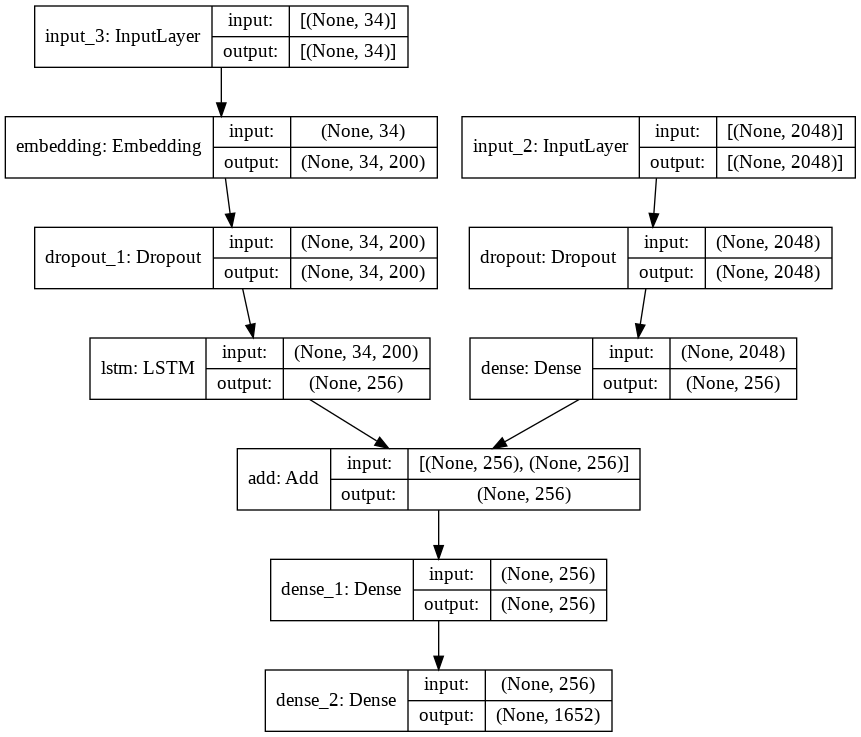

In [ ]:
# define the model - Encoder Decoder model
input1 = Input(shape = (2048, )) 
feature1 = Dropout(0.2)(input1) 
feature2 = Dense(256, activation = 'relu')(feature1) 
input2 = Input(shape = (max_length, )) 
sequence1 = Embedding(vocab_size, emb_dim, mask_zero = True)(input2) 
sequence2 = Dropout(0.2)(sequence1) 
sequence3 = LSTM(256)(sequence2) 
decoder1 = add([feature2, sequence3]) 
decoder2 = Dense(256, activation = 'relu')(decoder1) 
outputs = Dense(vocab_size, activation = 'softmax')(decoder2) 
model = Model(inputs = [input1, input2], outputs = outputs)
print(model.summary())

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

**Model Training**

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/flickr8k/caption.ckpt',
                                                 save_weights_only=True,
                                                 verbose=1)

#Not to train the embedding layer
model.layers[2].set_weights([emb_matrix]) 
model.layers[2].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam') 
model.fit([X1, X2], y, epochs = 100, batch_size = 256, callbacks=[cp_callback]) 
model.save('/content/drive/MyDrive/flickr8k/caption_model.h5')

Epoch 1/100
1142/1142 [==============================] - ETA: 0s - loss: 3.9021
Epoch 00001: saving model to /content/drive/MyDrive/flickr8k/caption.ckpt
1142/1142 [==============================] - 94s 82ms/step - loss: 3.9021
Epoch 2/100
1142/1142 [==============================] - ETA: 0s - loss: 3.1632
Epoch 00002: saving model to /content/drive/MyDrive/flickr8k/caption.ckpt
1142/1142 [==============================] - 93s 81ms/step - loss: 3.1632
Epoch 3/100
1142/1142 [==============================] - ETA: 0s - loss: 2.9301
Epoch 00003: saving model to /content/drive/MyDrive/flickr8k/caption.ckpt
1142/1142 [==============================] - 94s 82ms/step - loss: 2.9301
Epoch 4/100
1142/1142 [==============================] - ETA: 0s - loss: 2.7751
Epoch 00004: saving model to /content/drive/MyDrive/flickr8k/caption.ckpt
1142/1142 [==============================] - 95s 83ms/step - loss: 2.7751
Epoch 5/100
1142/1142 [==============================] - ETA: 0s - loss: 2.6597
Epoch 00

In [ ]:
from tensorflow import keras
model.load_weights('/content/drive/MyDrive/flickr8k/caption.ckpt')
#model = keras.models.load_model('/content/drive/MyDrive/flickr8k/caption_model.h5')

In [ ]:
#Test data
import glob 
images = '/content/drive/MyDrive/Flickr_Data/Images/'
# Create a list of all image names in the directory 
img = glob.glob(images + '*.jpg')

test_path = '/content/drive/MyDrive/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
test_images = open(test_path, 'r', encoding = 'utf-8').read().split("\n") 
test_img = []  # list of all images in training set 
for im in img: 
    #print(im[len(images):])
    if(im[len(images):] in test_images): 
        test_img.append(im)

**Inference**

In [ ]:
from keras.preprocessing.image import load_img, img_to_array 
def predict_caption(pic): 
    start = 'startofline'
    for i in range(max_length): 
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]    
        seq = pad_sequences([seq], maxlen = max_length) 
        yhat = model.predict([pic, seq], verbose = 0) 
        print(yhat)
        yhat = np.argmax(yhat) 
        print(yhat)
        word = ixtoword[yhat] 
        start += ' ' + word 
        if word == 'endofline': 
            break
    final = start.split() 
    final = final[1:-1] 
    final = ' '.join(final) 
    return final

def generate_feature(tst_img):
  base_model_1 = InceptionV3(weights = 'imagenet') 
  predict_model = Model(base_model_1.input, base_model_1.layers[-2].output) 
  img = load_img(tst_img, target_size = (299, 299)) 
  img = img_to_array(img)
  img_show = img/255
  plt.imshow(img_show)
  plt.show()
  img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
  img = preprocess_input(img)  
  feature = predict_model.predict(img, verbose=0)
  return feature

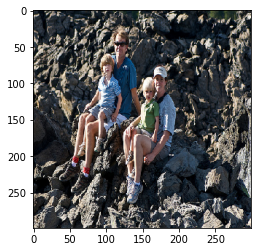

woman in red shirt and khaki pants sits on rocks near large


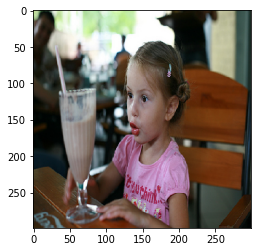

little boy is playing with green in the water


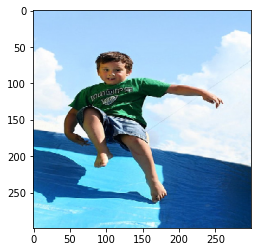

boy in red and white swimming suit does face


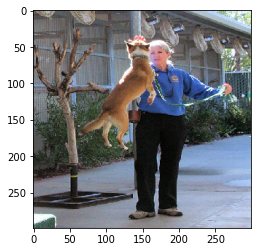

man and woman are standing in front of building that has been painted on the side of them


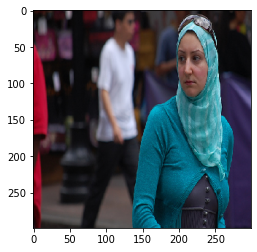

man wearing red jacket is standing in crowd


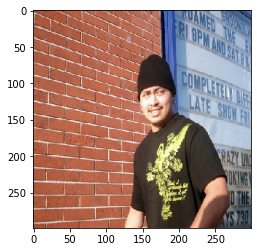

man in red jacket and leather jacket is taking photo of man in orange


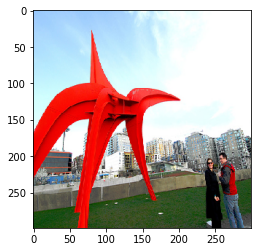

the boy is performing jump on the slide


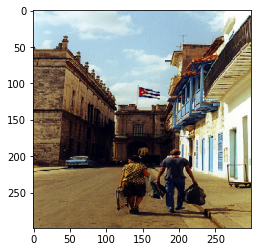

man in blue jacket is walking past snow


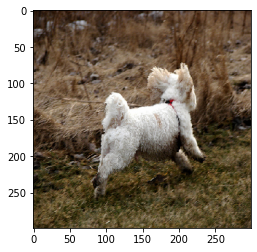

white dog is running through the dirt


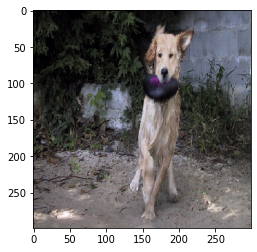

dog is running through the grass


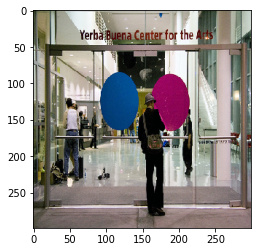

man in black jacket is standing in front of crowd


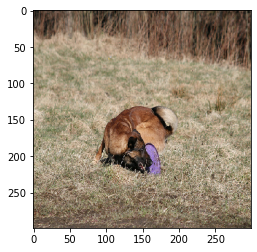

brown dog runs through field


In [ ]:
for i, tst_img in enumerate(test_img):
  feature = generate_feature(tst_img)
  final_caption = predict_caption(feature)
  print(final_caption)
  if i>10:
    break